In [1]:
!conda list | grep -E "(python|scikit|tensor)"

ipython                   8.20.0          py310haa95532_0  
ipython_genutils          0.2.0              pyhd3eb1b0_1  
python                    3.10.13              h966fe2a_0  
python-dateutil           2.8.2              pyhd3eb1b0_0  
python-fastjsonschema     2.16.2          py310haa95532_0  
python-flatbuffers        2.0                pyhd3eb1b0_0  
python-json-logger        2.0.7           py310haa95532_0  
python-tzdata             2023.3             pyhd3eb1b0_0  
scikit-learn              1.3.0           py310h4ed8f06_1  
tensorboard               2.10.0          py310haa95532_0  
tensorboard-data-server   0.6.1           py310haa95532_0  
tensorboard-plugin-wit    1.8.1           py310haa95532_0  
tensorflow                2.10.0          mkl_py310hd99672f_0  
tensorflow-base           2.10.0          mkl_py310h6a7f48e_0  
tensorflow-estimator      2.10.0          py310haa95532_0  
types-python-dateutil     2.8.19.20240311          pypi_0    pypi


# PDP and ICE with bike shareing demand data
- PartiolDependenceDisplay 패키지를 사용하여 모델로부터 PDP와 ICE 플롯을 얻는다.
   - MLPRegressor와 HistGradienetBoostingRegressor 사용
   - MLPR : multi-layer perceptrone 계열
   - HistGBR : gradient boosting 계열
- partial dependence plot : 부분 의존성 플롯
   - target과 독립변수 사이의 의존성을 나타낸다. (몇가지 선택)
   - 다른 독립변수의 가치를 무시한다.(주변 확률 밀도함수를 사용한 계산)
   - 가장 중요한 독립변수 1~2개를 선택한다.
   - PDD 패키지의 파라미터 중 kind="average"
- ICE : individual conditional expectation
   - 개별 샘플 데이터의 조건부 기댓값은 target과 관심 독립변수간의 종속성을 보여준다.
   - 샘플 하나의 특성에 대한 예측의 종속성을 개별적으로 시각화 해준다.
   - PDD 패키지의 파라미터 중 kind="both"
- 독립변수의 상호작용(interaction)을 사용하여 2-way ICE를 사용할 수 있다.
- 모델링 방법
   - 전처리기
      - from sklearn. import ColumnTransformer
      - numeric cols : QuantileTransformer()
      - category cols : OneHotEncoder(), OrdinalEncoder()
   - 파이프라인
      - from sklearn.pipeline import make_pipeline
   - 모델링
      - from sklearn.neural_network import MLPRegressor
      - from sklearn.ensemble import HistGradientBoostingRegressor()
   - PDP, ICE 플롯
      - from sklearn. import PartialDependenceDisplay

## 자전거 대여 건수 예측
- openml에서 Bike_Sharing_Demand 데이터 version 2 사용

```
fetch_openml에서 데이터를 임포트 하지 못할 때 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
```

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
X, y= bikes.data.copy(), bikes.target

X.shape, y.shape

((17379, 12), (17379,))

In [4]:
print(bikes.DESCR)

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected tha

In [5]:
bikes.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
bikes.frame.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [7]:
X.tail()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981
17378,spring,1,12,23,False,1,True,clear,10.66,13.635,0.65,8.9981


In [8]:
y.tail()

17374    119
17375     89
17376     90
17377     61
17378     49
Name: count, dtype: int64

### feature : weather 희귀값 변환
- havy_rain 값은 매우 유니크한 값이다.
   - 많은 비가 내린 날은 하루
- heavy_rain 값을 rain 값으로 변환

In [9]:
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

In [10]:
%matplotlib inline

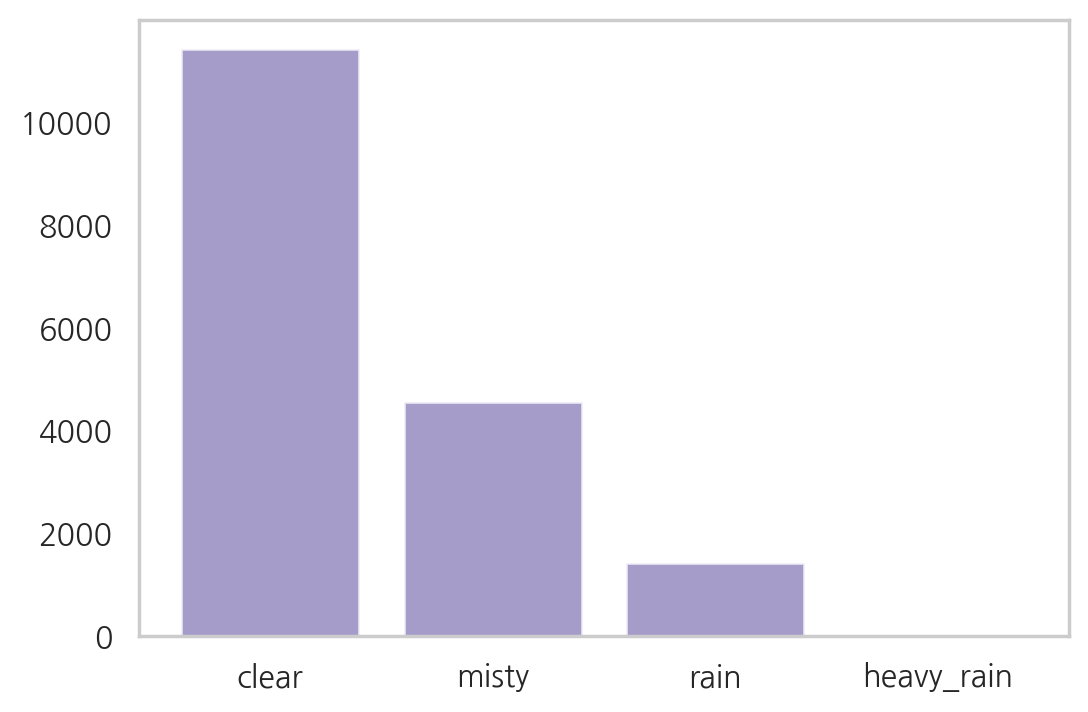

In [11]:
x1 = list(dict(X["weather"].value_counts()).keys())
y1 = list(dict(X["weather"].value_counts()).values())

plt.figure(figsize=(6, 4))
plt.bar(x1, y1, color="m", alpha=0.7)
plt.grid(False)
plt.show() ; 

In [12]:
X["weather"].astype(object).info()

<class 'pandas.core.series.Series'>
RangeIndex: 17379 entries, 0 to 17378
Series name: weather
Non-Null Count  Dtype 
--------------  ----- 
17379 non-null  object
dtypes: object(1)
memory usage: 135.9+ KB


In [13]:
X["weather"] = (X["weather"]\
                .astype(object)\
                .replace(to_replace="heavy_rain", value="rain")\
                .astype("category"))
X["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

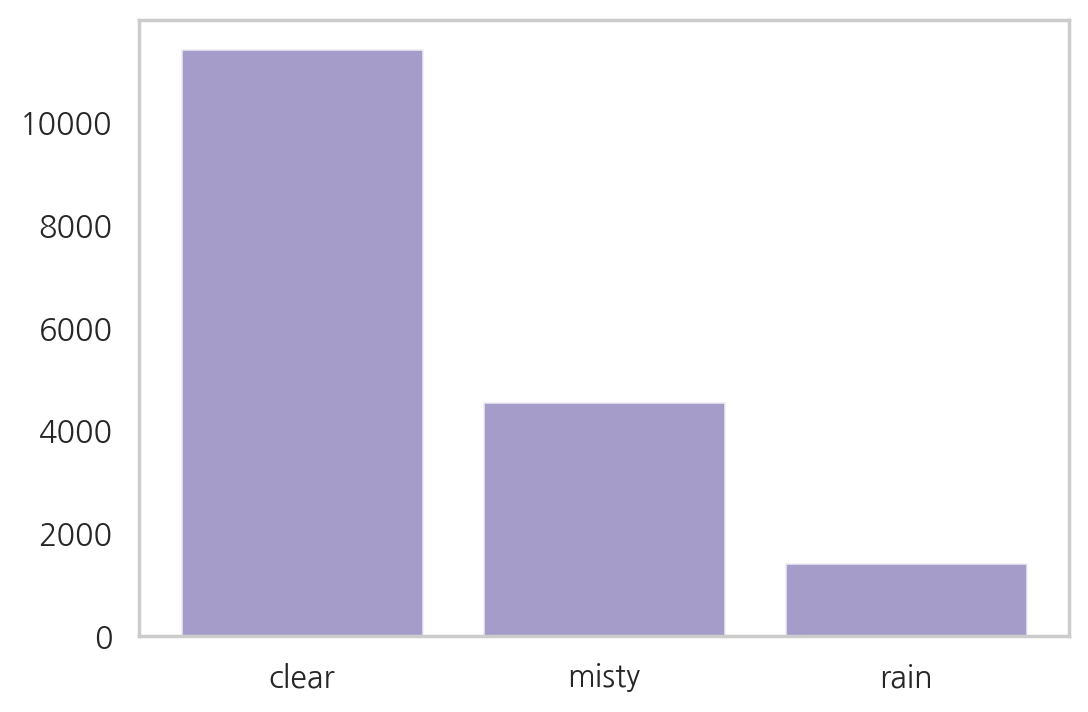

In [14]:
x1 = list(dict(X["weather"].value_counts()).keys())
y1 = list(dict(X["weather"].value_counts()).values())

plt.figure(figsize=(6, 4))
plt.bar(x1, y1, color="m", alpha=0.7)
plt.grid(False)
plt.show() ; 

### feature : year
- year 독립변수의 값에서 0.0, 1.0을 구분하여 train, test 세트 분리
   - train : 2010년 : 0.0
   - test : 2011년 : 1.0
- 2010년 데이터를 통해서 2011년 수요를 예측하기 위함

In [15]:
X["year"].value_counts()

year
1    8734
0    8645
Name: count, dtype: int64

In [16]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [17]:
X_train.shape[0] == mask_training.sum()

True

In [18]:
X_test.shape[0] == (X.shape[0] - mask_training.sum())

True

### categorical 컬럼과 numeric feature 컬럼 구분
- 모델링에서 전처기를 통하여 각각 다른 전처리 방법을 사용함
   - 범주형 독립변수 : season, month, holiday, workingday, weekday, hour
   - 숫자형 독립변수 : temp, feel_temp, humidity, widspeed

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8645 entries, 0 to 8644
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8645 non-null   category
 1   month       8645 non-null   int64   
 2   hour        8645 non-null   int64   
 3   holiday     8645 non-null   category
 4   weekday     8645 non-null   int64   
 5   workingday  8645 non-null   category
 6   weather     8645 non-null   category
 7   temp        8645 non-null   float64 
 8   feel_temp   8645 non-null   float64 
 9   humidity    8645 non-null   float64 
 10  windspeed   8645 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 574.7 KB


#### preprocessore에서 사용함

In [20]:
num_cols = ["temp", "feel_temp", "humidity", "windspeed"]

cate_cols = X_train.columns.drop(num_cols)
cate_cols

Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')

### bike rental 그래프 
- 계절별, 연도별 그룹화 후 평균 자전거 대여 횟수
   - PDP, ICE 그래프에서 독립변수와 종속변수의 의존성과 유사한 패턴을 확인 할 수 있다.   

In [21]:
from itertools import product

In [22]:
days = ("sun", "mon", "tue", "wed", "thu", "fri", "sat")
days

('sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat')

In [23]:
hours = tuple(range(24))
print(hours)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)


In [24]:
xtick_labels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
print(xtick_labels[:25])

['sun\n0:00', 'sun\n1:00', 'sun\n2:00', 'sun\n3:00', 'sun\n4:00', 'sun\n5:00', 'sun\n6:00', 'sun\n7:00', 'sun\n8:00', 'sun\n9:00', 'sun\n10:00', 'sun\n11:00', 'sun\n12:00', 'sun\n13:00', 'sun\n14:00', 'sun\n15:00', 'sun\n16:00', 'sun\n17:00', 'sun\n18:00', 'sun\n19:00', 'sun\n20:00', 'sun\n21:00', 'sun\n22:00', 'sun\n23:00', 'mon\n0:00']


In [25]:
xtick_start, xtick_period = 6, 12
xtick_start, xtick_period

(6, 12)

In [26]:
average_bike_rentals = bikes.frame.groupby(["year", "season", "weekday", "hour"], observed=True).mean(numeric_only=True)["count"]
average_bike_rentals

year  season  weekday  hour
0     fall    0        0       111.916667
                       1        86.000000
                       2        74.166667
                       3        38.333333
                       4         6.583333
                                  ...    
1     winter  6        19      283.166667
                       20      213.000000
                       21      197.250000
                       22      164.750000
                       23      143.416667
Name: count, Length: 1344, dtype: float64

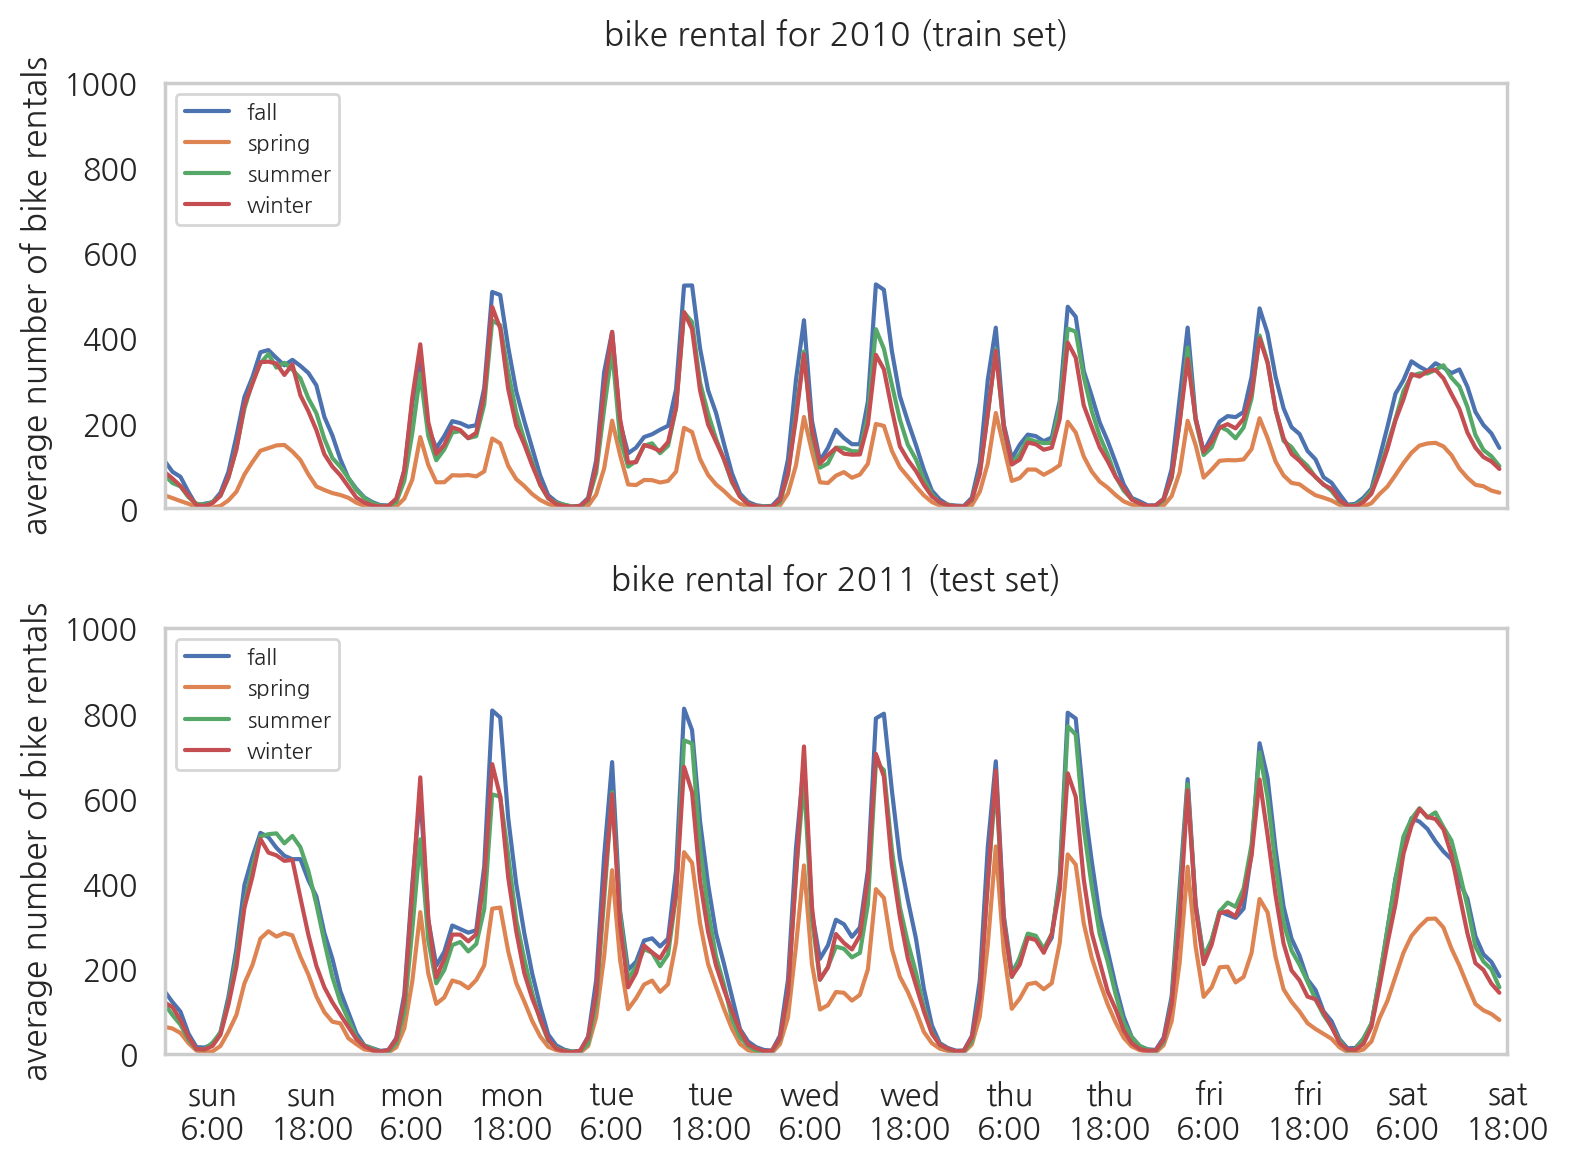

In [27]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)

for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")) : 
    df.groupby("season", observed=True).plot(ax=ax, legend=True, grid=False)
    
    ax.set_xticks(np.linspace(start=xtick_start, 
                              stop=len(xtick_labels),
                              num=len(xtick_labels) // xtick_period))
    ax.set_xticklabels(xtick_labels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("average number of bike rentals")
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, len(xtick_labels))
    ax.legend(loc=2, prop={'size': 8}) # legend의 글자크기 조정
    ax.set_title(f"bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}", y=1.05)

plt.tight_layout()
plt.show() ;

In [28]:
np.linspace(start=xtick_start, stop=len(xtick_labels),
                             num=len(xtick_labels) // xtick_period)

array([  6.        ,  18.46153846,  30.92307692,  43.38461538,
        55.84615385,  68.30769231,  80.76923077,  93.23076923,
       105.69230769, 118.15384615, 130.61538462, 143.07692308,
       155.53846154, 168.        ])

In [29]:
len(xtick_labels)

168

In [30]:
len(xtick_labels) // xtick_period

14

## ML model
- 범주형 독립변수를 전처리해서 모델 fitting에 도움이 될 수 있다.
- feature 전처리기
   - MLPRegressor, HistGradientBoostingRegressor 각각 따로 독립변수 전처리기 생성
- OneHotEncoder() : 모든 범주형 값을 0과 1의 배열로 변환
   - [["red", "blue"]] : [[1, 0], [0, 1]]
   - 값의 종류가 많은 경우 불필요한 컬럼이 오히려 늘어난다. 
   - 0만 있는 컬럼이 생길 수 있음
- OrdinalEncoder() : 모든 범주형 값 각각에 0~(범주형 값의 종류 갯수-1)의 숫자로 변환
   - [["red", "blue"]] : [[0, 1]]
   - 독립변수 하나에서 각 카데고리값을 숫자로 바꿔줌

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

In [32]:
num_cols

['temp', 'feel_temp', 'humidity', 'windspeed']

In [33]:
cate_cols

Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')

In [34]:
mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cate_cols)
    ])
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

In [35]:
from sklearn.preprocessing import OrdinalEncoder

In [36]:
hgb_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OrdinalEncoder(), cate_cols)
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False
).set_output(transform="pandas")

hgb_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))],
                  verbose_feature_names_out=False)

### OneHotEncoder(), OrdinalEncoder() 테스트

In [37]:
sample_df = pd.DataFrame({"col_1": ["hong", "kim", "yoon"],
                         "col_2": ["naver", "daum", "google"],
                         "col_3": ["daum", "daum", "naver"]},
                        columns=["col_1", "col_2", "col_3"])
sample_df

,col_1,col_2,col_3
0,hong,naver,daum
1,kim,daum,daum
2,yoon,google,naver


In [38]:
ordinal_enc = OrdinalEncoder()
ordinal_enc.fit(np.array(sample_df["col_2"]).reshape(-1, 1))
ordinal_enc.transform(np.array(sample_df["col_3"]).reshape(-1, 1))

array([[0.],
       [0.],
       [2.]])

In [39]:
ordinal_enc.fit_transform(np.array(X["weather"][:10]).reshape(-1, 1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
onehot_enc = OneHotEncoder()
onehot_enc.fit_transform(np.array(sample_df["col_2"]).reshape(-1, 1)).toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

## ML을 사용하여 단방향 부분 의존성 계산
- PDP : partial dependence plot : 부분 의존도 plot
- ICE : indivisual conditional expectation : 개별 조건부 기대값

### MLPRegressor

In [41]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

In [42]:
from time import time

In [43]:
print("Trining MLPRegressor...")

tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor, 
    MLPRegressor(
        hidden_layer_sizes=(30, 15), 
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0))

mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic :.3f}s")
print(f"Test R2 score : {mlp_model.score(X_test, y_test):.2f}")

Trining MLPRegressor...
done in 1.900s
Test R2 score : 0.61


In [44]:
mlp_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  QuantileTransformer(n_quantiles=100),
                                                  ['temp', 'feel_temp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(30, 15),
                              learning_rate_init=0.01, random_state=0))])

### partial dependence plot
- temp 값이 커질 수록 target 값도 커진다.
   - temp와 target은 양의 상관관계가 있다.
- humidity 값이 커질 수록 target 값은 작아진다.
   - 습도와 target은 음의 상관관계가 있다.
   - windspeed도 비슷한 양상이다.
- season 독립변수의 spring 카테고리 값은 count와 상관관계가 작다.
- weather 독립변수의 rain 카테고리 값은 count와 상관관계가 작다.
- hour 독립변수의 경우 오전7시에서 저녁 6시사이에 두번의 피크점이 있다.
- 이와 같은 결과는 rantal 그래프에서도 찾아볼 수 있다.
- MLP가 HGB 보다 더 부드러운 곡선이다.

In [45]:
from sklearn.inspection import PartialDependenceDisplay

In [46]:
common_params = {
    "subsample": 50,
    "n_jobs": 1,
    "grid_resolution": 20,
    "random_state": 0
}

features_info = {
    # features of interesting
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": cate_cols
}


In [47]:
common_params["subsample"], features_info["kind"]

(50, 'average')

computing partial dependence plots...
done in 1.861s


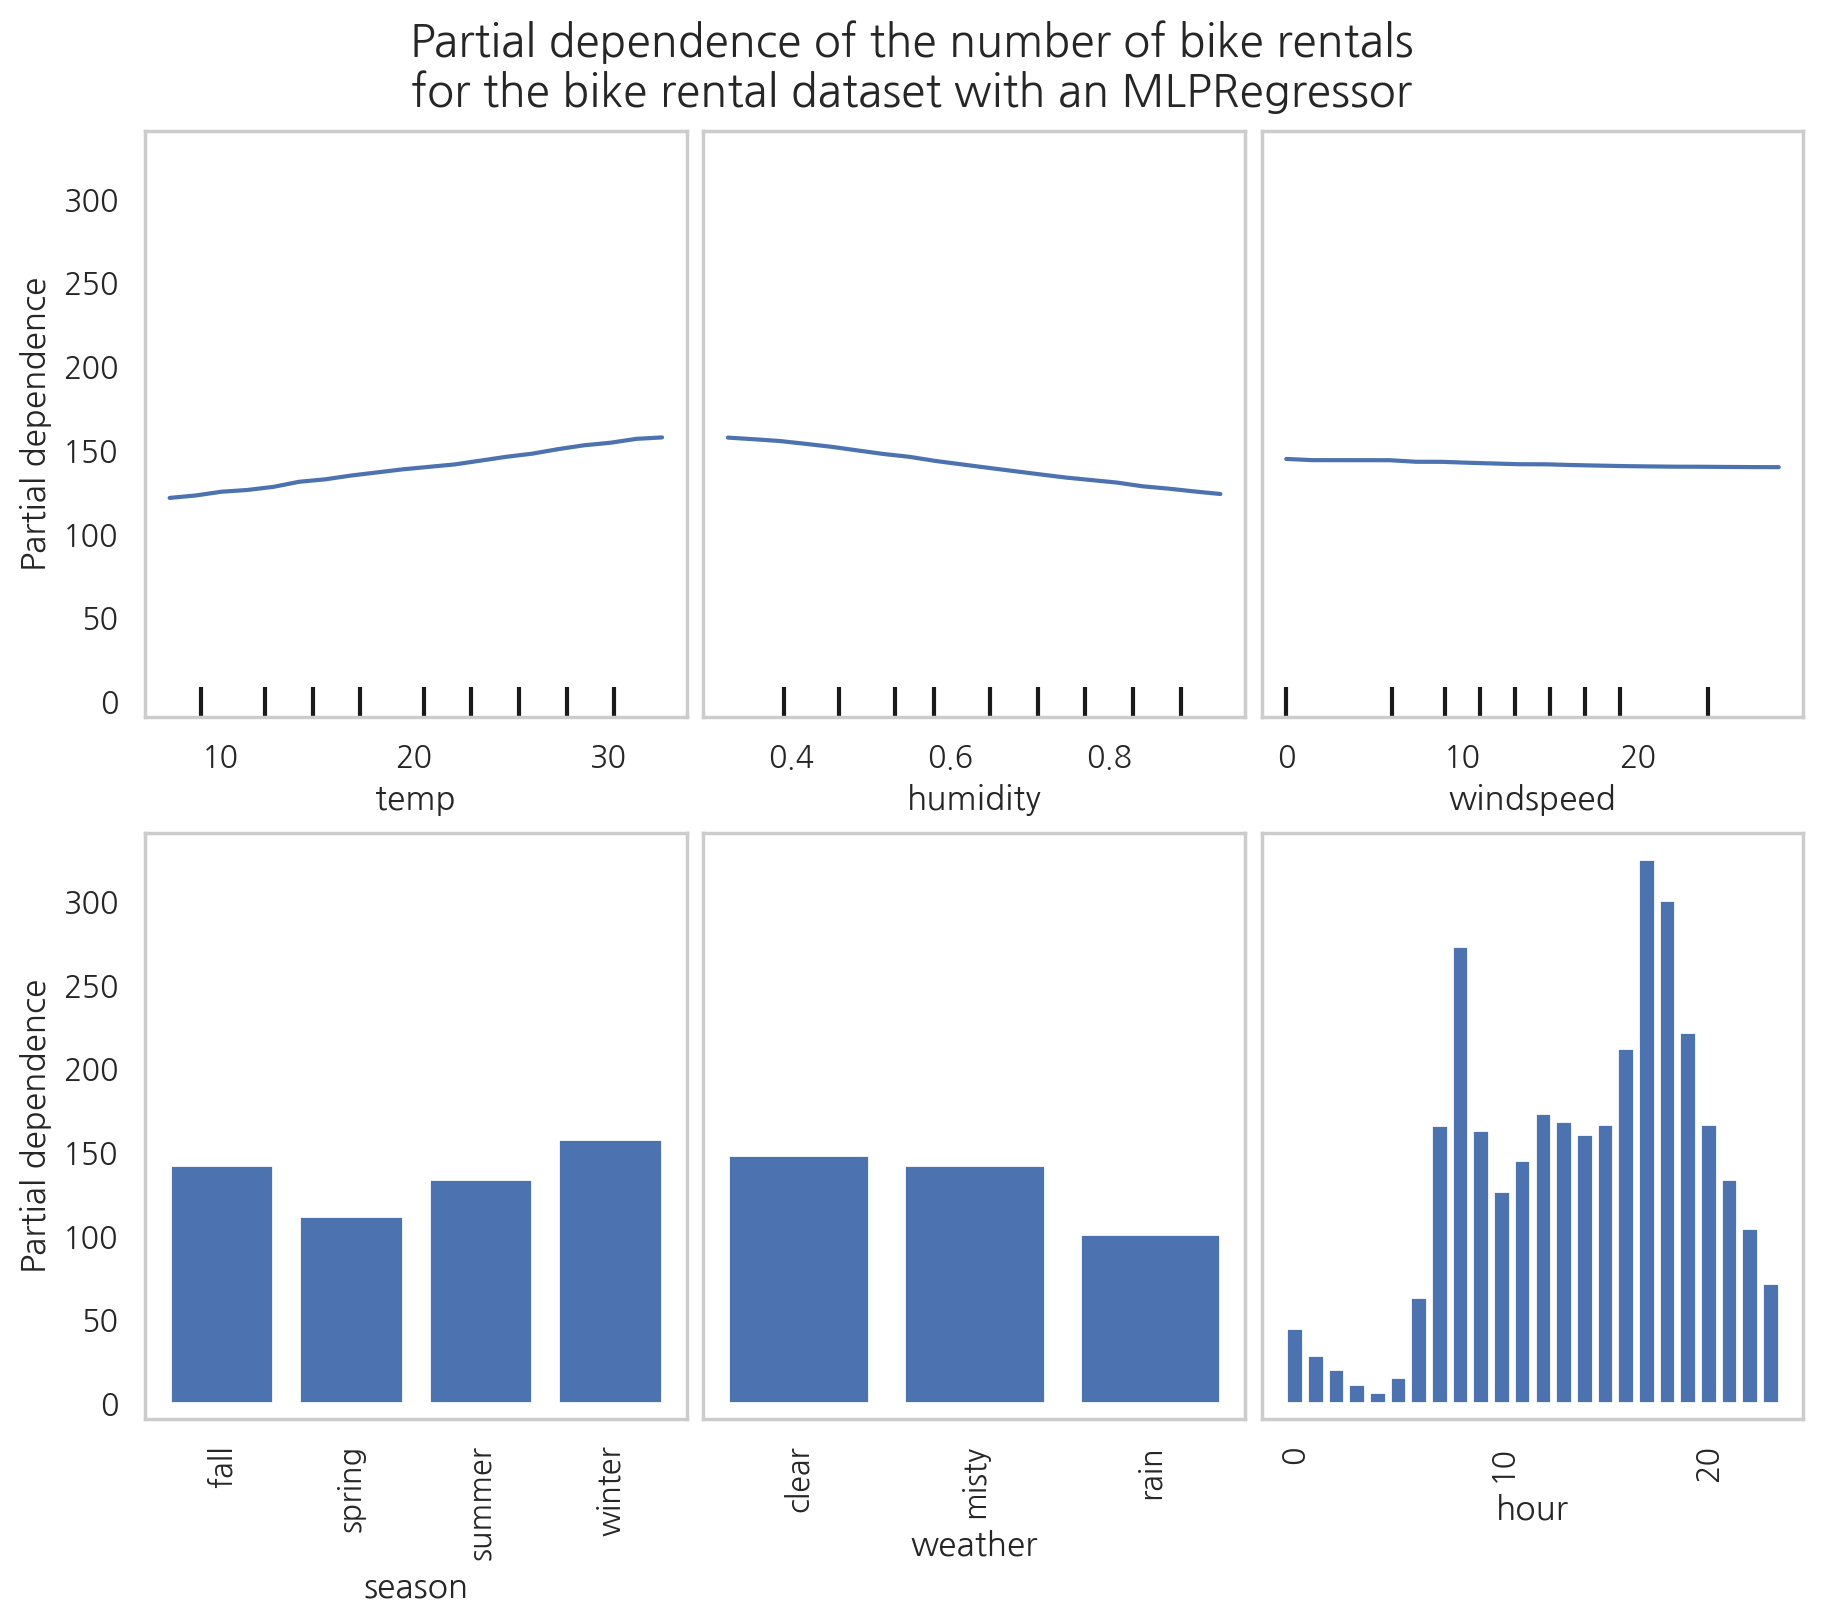

In [48]:
print("computing partial dependence plots...")
tic = time()

plt.rcParams["axes.grid"] = False
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params)

print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with an MLPRegressor"
    ), 
    fontsize=16
)

### HistGBR

In [49]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [50]:
print("Training HGBR model...")

tic = time()
hgb_model = make_pipeline(
    hgb_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=cate_cols,
        learning_rate=0.2,
        max_iter=50,
        random_state=0)
)

hgb_model.fit(X_train, y_train)
print(f"done in: {time() - tic:.3f}s")
print(f"Test R2 score: {hgb_model.score(X_test, y_test):.2f}")

Training HGBR model...
done in: 0.553s
Test R2 score: 0.64


In [51]:
hgb_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('num', 'passthrough',
                                                  ['temp', 'feel_temp',
                                                   'humidity', 'windspeed']),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'),
                                               learning_rate=0.2, max_iter=50,
                                               random_state=0))])

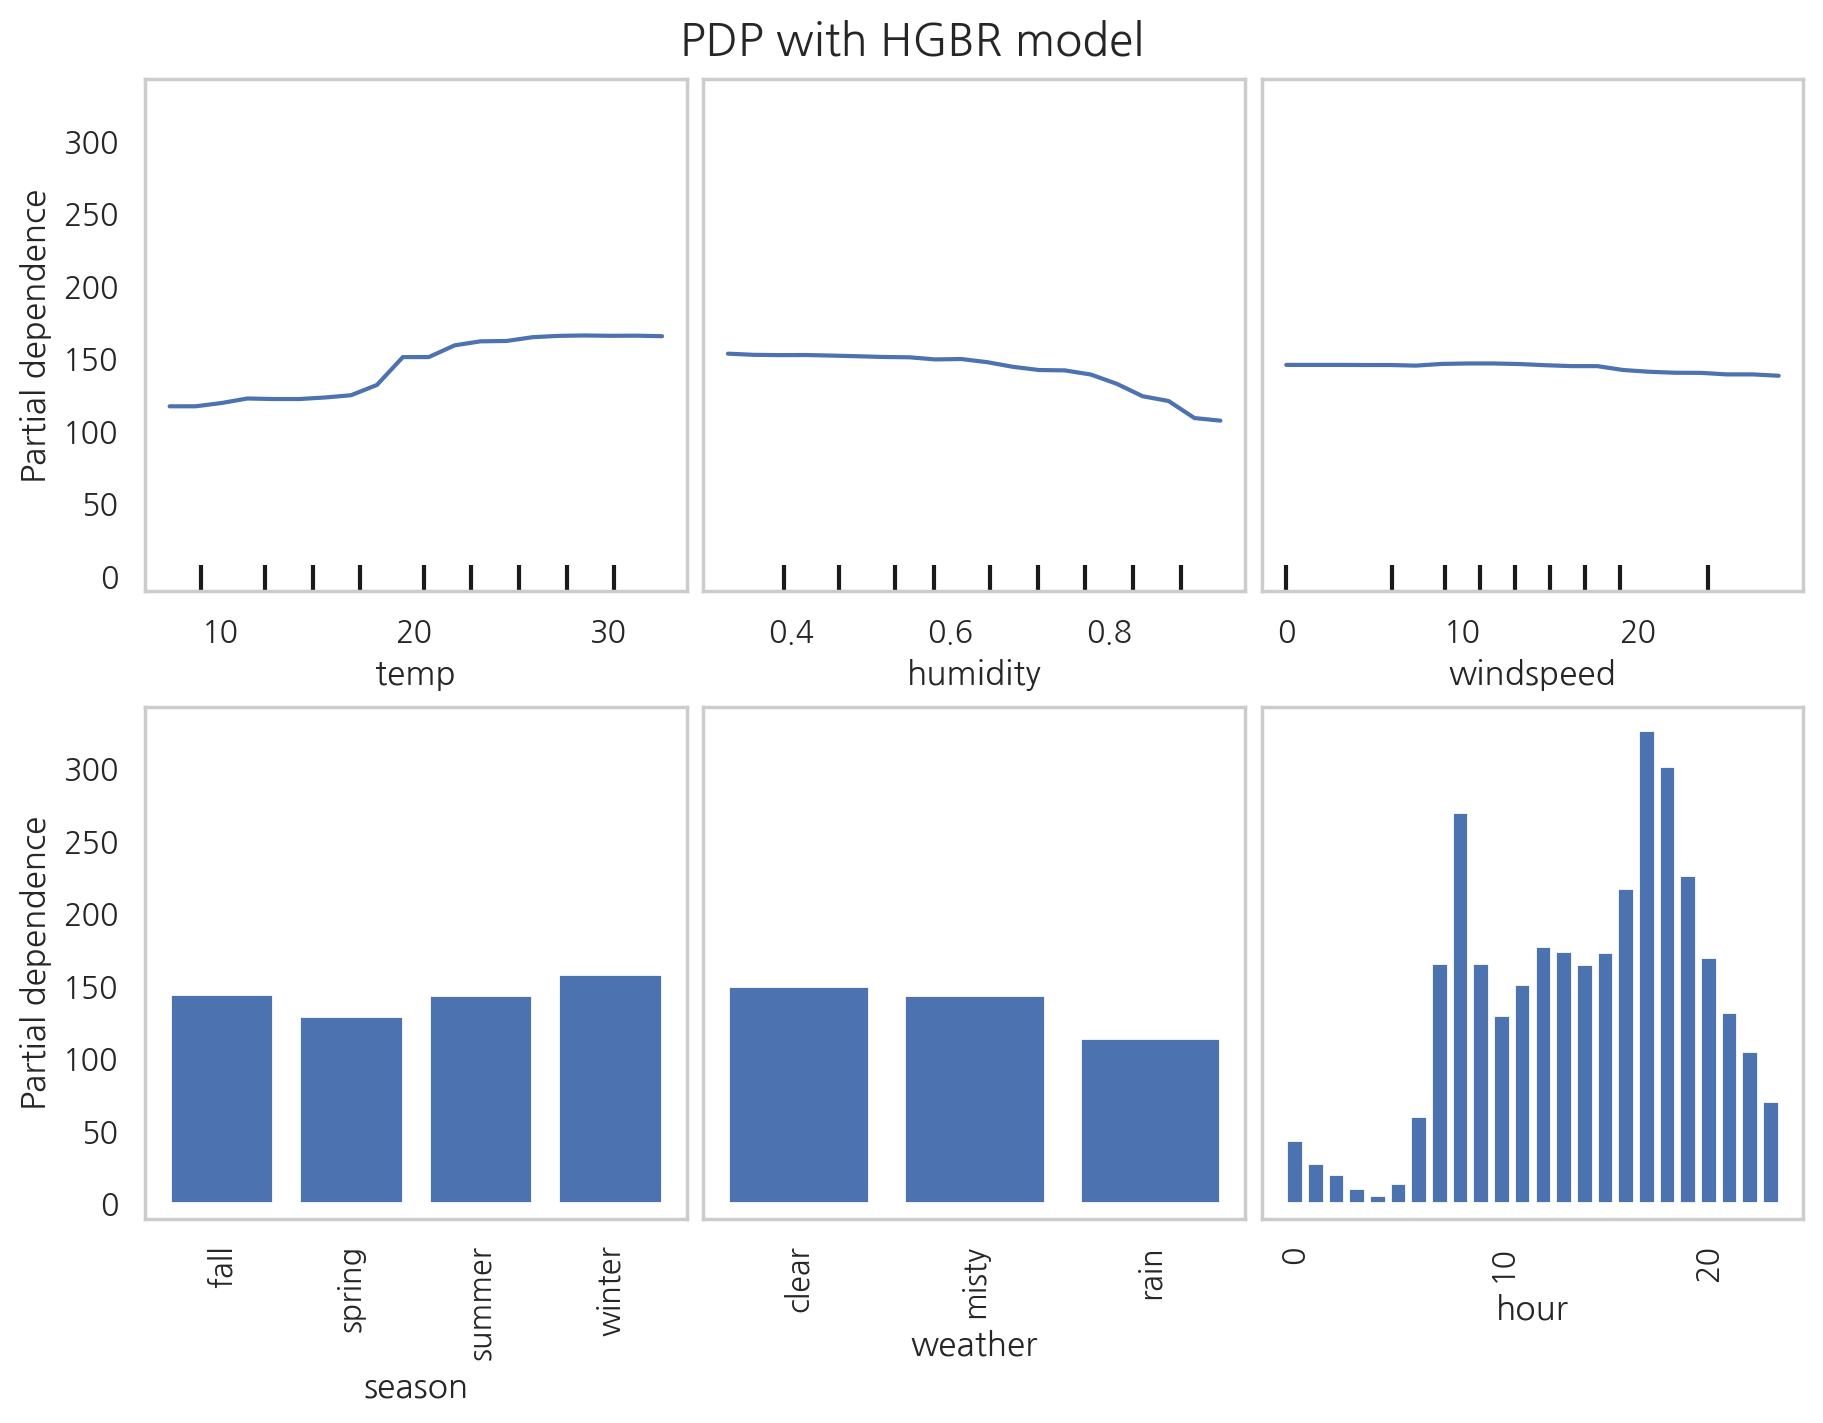

In [52]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 7), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgb_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params
)

_ = display.figure_.suptitle("PDP with HGBR model", fontsize=16)

## ICE : individual conditional estimator
- pdd 패키지의 kind 파라미터의 값을 both로 설정한다.
- temp의 ICE 라인 중 어떤 것은 주요 경향과 다른 패턴을 보이는 것들이 있다.
   - 평균에서 크게 벗어나거나 급격히 변하는 선들
- 이러한 이유는 독립변수간에 상호작용(interactions)이 있기 때문이다.
- interaction_cst : 특징벡터간의 상호작용을 제거해주는 매개변수

computing ICE with HGBR model...
done in: 1.106s


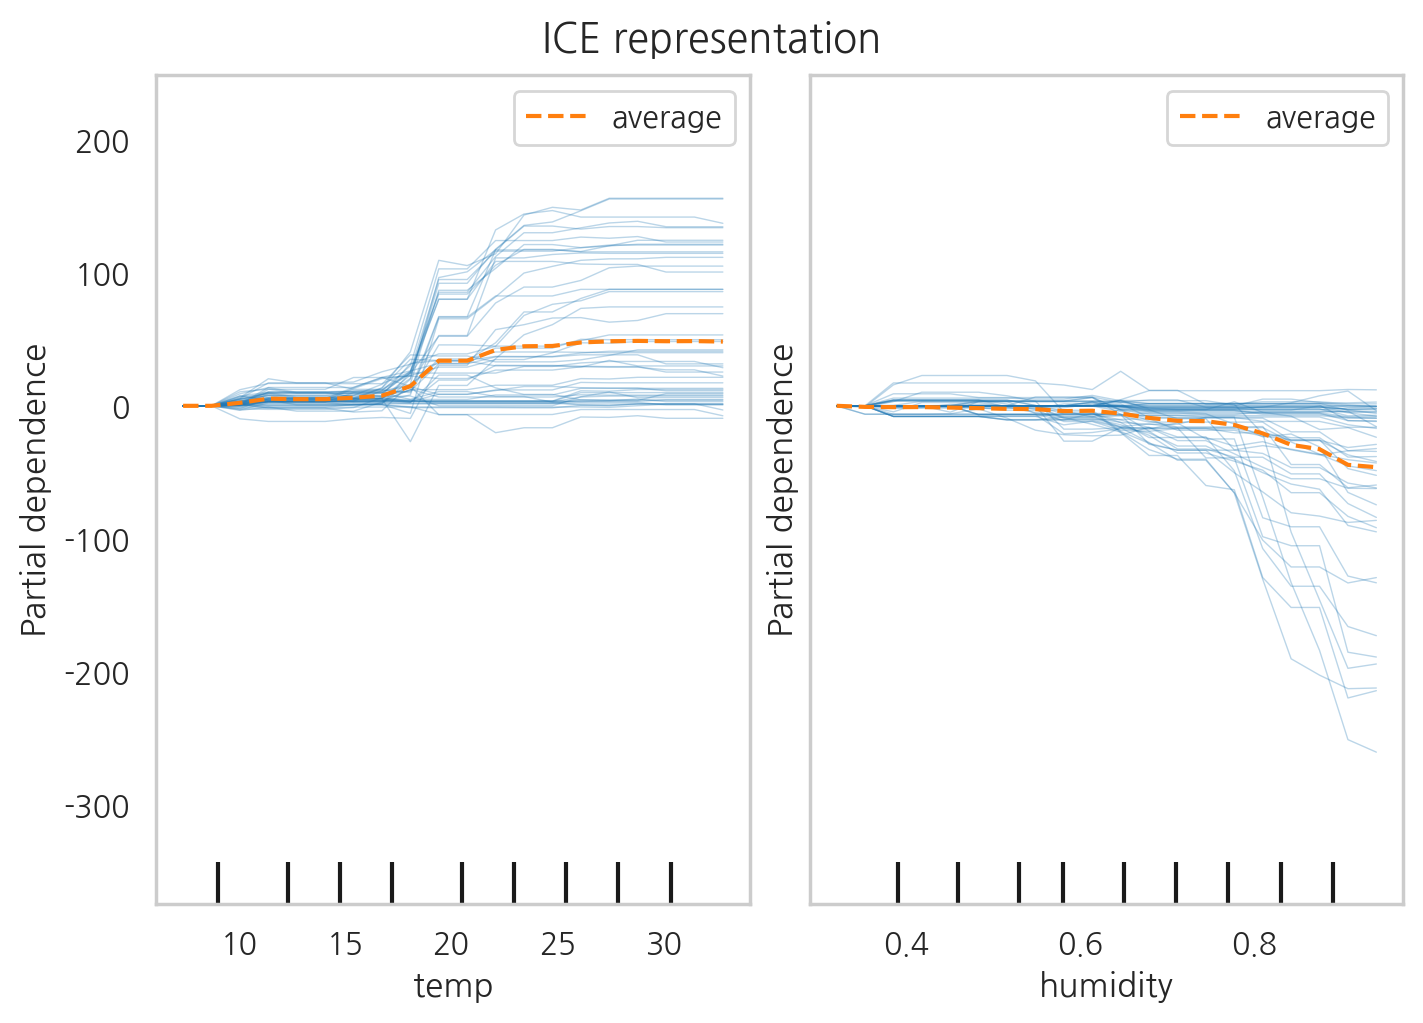

In [60]:
print("computing ICE with HGBR model...")
tic = time()

_, ax = plt.subplots(ncols=2, figsize=(7, 5), sharey=True, constrained_layout=True)
features_info_ice = {
    "features": ["temp", "humidity"],
    "kind": "both", # PDP는 average, ICE는 both
    "centered": True
}

display = PartialDependenceDisplay.from_estimator(
    hgb_model,
    X_train,
    **features_info_ice,
    ax=ax,
    **common_params
)

print(f"done in: {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE representation")

### interaction 제거
- clone 패키지를 사용하여 모델을 심층복사하여 새추정기를 만들고
- set_params 속성을 사용하여 모델의 interaction_cst 파라미터를 설정한 후
- 모델을 학습시키다.
- clone 패키지
   - 동일한 모수(parameter)를 사용하여 새로운 unfitted estimator를 만든다.
   - 데이터를 복사하지 않고 추정기에서 모형의 심층 복사를 한다.
   - 어떤 데이터에도 사용하지 않은 새추정기를 반환한다.
- 상호작용을 제거하면 선의 형태가 일정해진다.   

In [53]:
from sklearn.base import clone

In [54]:
help(clone)

Help on function clone in module sklearn.base:

clone(estimator, *, safe=True)
    Construct a new unfitted estimator with the same parameters.
    
    Clone does a deep copy of the model in an estimator
    without actually copying attached data. It returns a new estimator
    with the same parameters that has not been fitted on any data.
    
    .. versionchanged:: 1.3
        Delegates to `estimator.__sklearn_clone__` if the method exists.
    
    Parameters
    ----------
    estimator : {list, tuple, set} of estimator instance or a single             estimator instance
        The estimator or group of estimators to be cloned.
    safe : bool, default=True
        If safe is False, clone will fall back to a deep copy on objects
        that are not estimators. Ignored if `estimator.__sklearn_clone__`
        exists.
    
    Returns
    -------
    estimator : object
        The deep copy of the input, an estimator if input is an estimator.
    
    Notes
    -----
    If the e

In [55]:
# column에 해당하는 넘버링

interaction_cst = [[i] for i in range(X_train.shape[1])]
interaction_cst

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

In [56]:
# HGBR의 파라미터인 interaction_cst를 set_params 매서드를 사용해 설정

hgb_model_without_interaction = (
    clone(hgb_model)
    .set_params(histgradientboostingregressor__interaction_cst=interaction_cst)
    .fit(X_train, y_train)
)

print(f"Test R2 score: {hgb_model_without_interaction.score(X_test, y_test):.2f}")

Test R2 score: 0.42


In [57]:
hgb_model_without_interaction

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('num', 'passthrough',
                                                  ['temp', 'feel_temp',
                                                   'humidity', 'windspeed']),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'),
                                               interaction_cst=[[0], [1], [2],
                                                                [3], [4], [5],
                                                                [6], [7], [8],
                                                                [9], [10]],
                                               learning_rate=0.2, max_iter=50,
                                               random_state=0))])

### 상호작용을 제거한 ICE
- feature 간의 상호작용을 사용하지 않으므로 각 데이터 샘플과 target의 의존성은 평행해진다.

In [64]:
features_info_ice = {
    "features": ["temp", "humidity"],
    "kind": "both", # PDP는 average, ICE는 both
    "centered": True
}
features_info_ice

{'features': ['temp', 'humidity'], 'kind': 'both', 'centered': True}

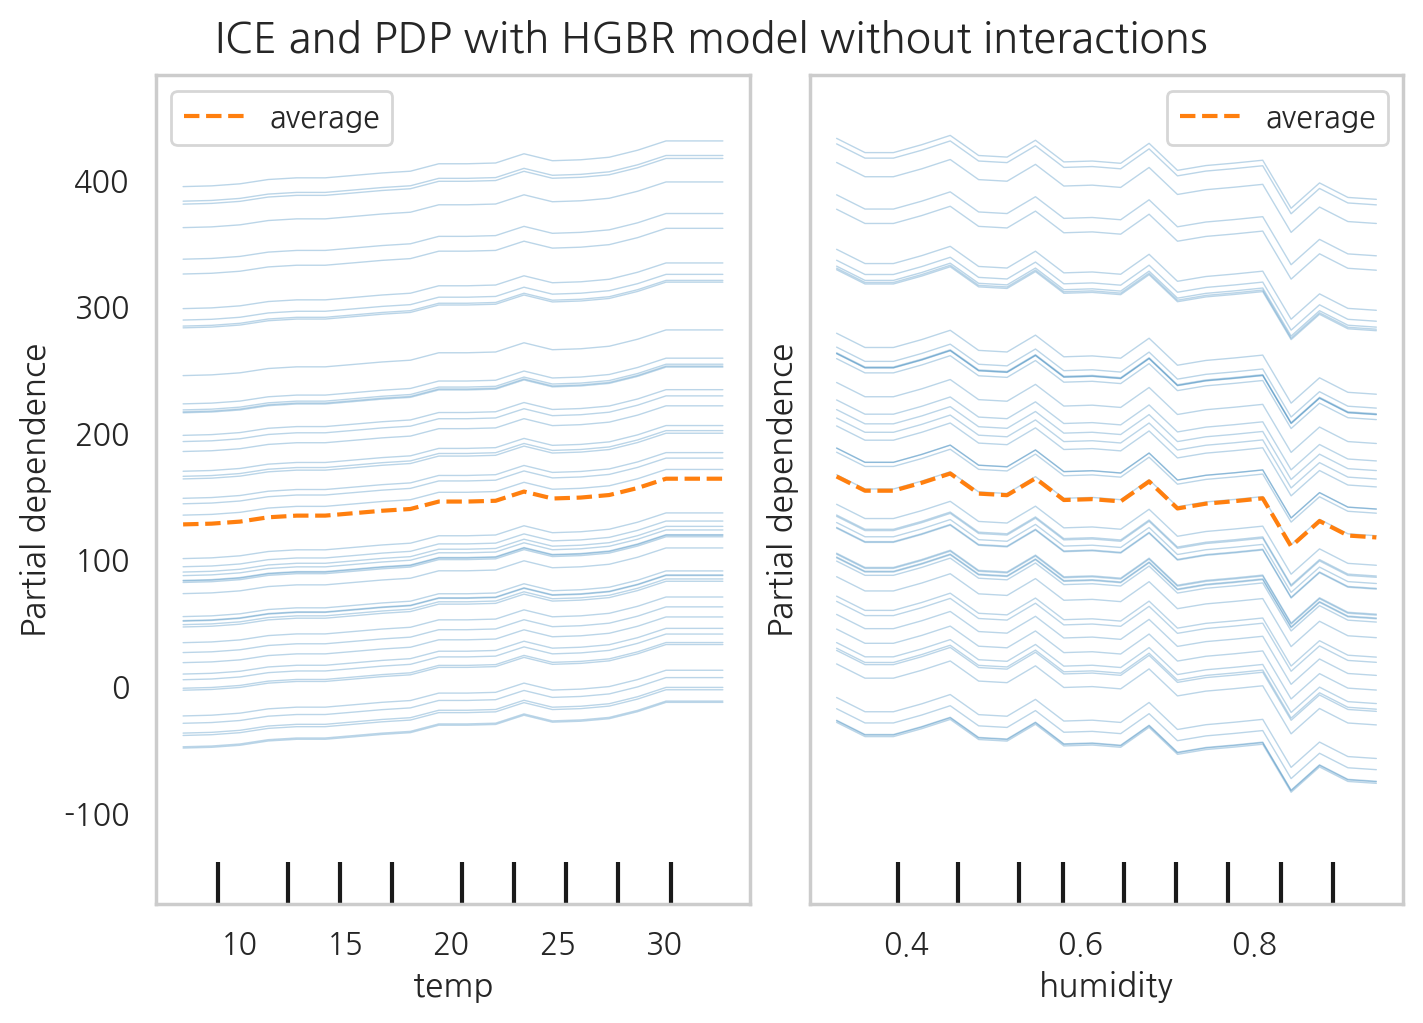

In [65]:
_, ax = plt.subplots(ncols=2, figsize=(7, 5), sharey=True, constrained_layout=True)

features_info_ice["centered"] = False
display = PartialDependenceDisplay.from_estimator(
    hgb_model_without_interaction,
    X_train,
    **features_info_ice,
    ax=ax,
    **common_params
)

_ = display.figure_.suptitle("ICE and PDP with HGBR model without interactions",
                            fontsize=15)

### clone 테스트
- model A를 심층복사 한 colne model

In [66]:
clone(hgb_model).set_params(
    histgradientboostingregressor__interaction_cst=interaction_cst,
    histgradientboostingregressor__max_depth=3
    )

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('num', 'passthrough',
                                                  ['temp', 'feel_temp',
                                                   'humidity', 'windspeed']),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'),
                                               interaction_cst=[[0], [1], [2],
                                                                [3], [4], [5],
                                                                [6], [7], [8],
                                                                [9], [10]],
                                               learning_rate=0.2, max_depth=3,
                                               max_iter=50, random_state=0))])

## 2-way PDP
- 양방향 부분 의존성 플롯
   - PDD 객체의 파라미터인 features에 분석할 대상 feature를 tuple에 담아서 저장
- 1-way는 temp와 humidity 그래프 
   - temp와 humidity의 그래프는 3D 곡면을 각각의 방향에서 바라본 모습
- 2-way는 히트맵
   - 히트맵의 선은 등고선 
   - 각 선의 간격은 지형의 경사의 정도, 선의 간격이 좁을 수록 경사가 가파른것.

In [67]:
features_info["features"] = ["temp", "humidity", ("temp", "humidity")]
features_info

{'features': ['temp', 'humidity', ('temp', 'humidity')],
 'kind': 'average',
 'categorical_features': Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
        'weather'],
       dtype='object')}

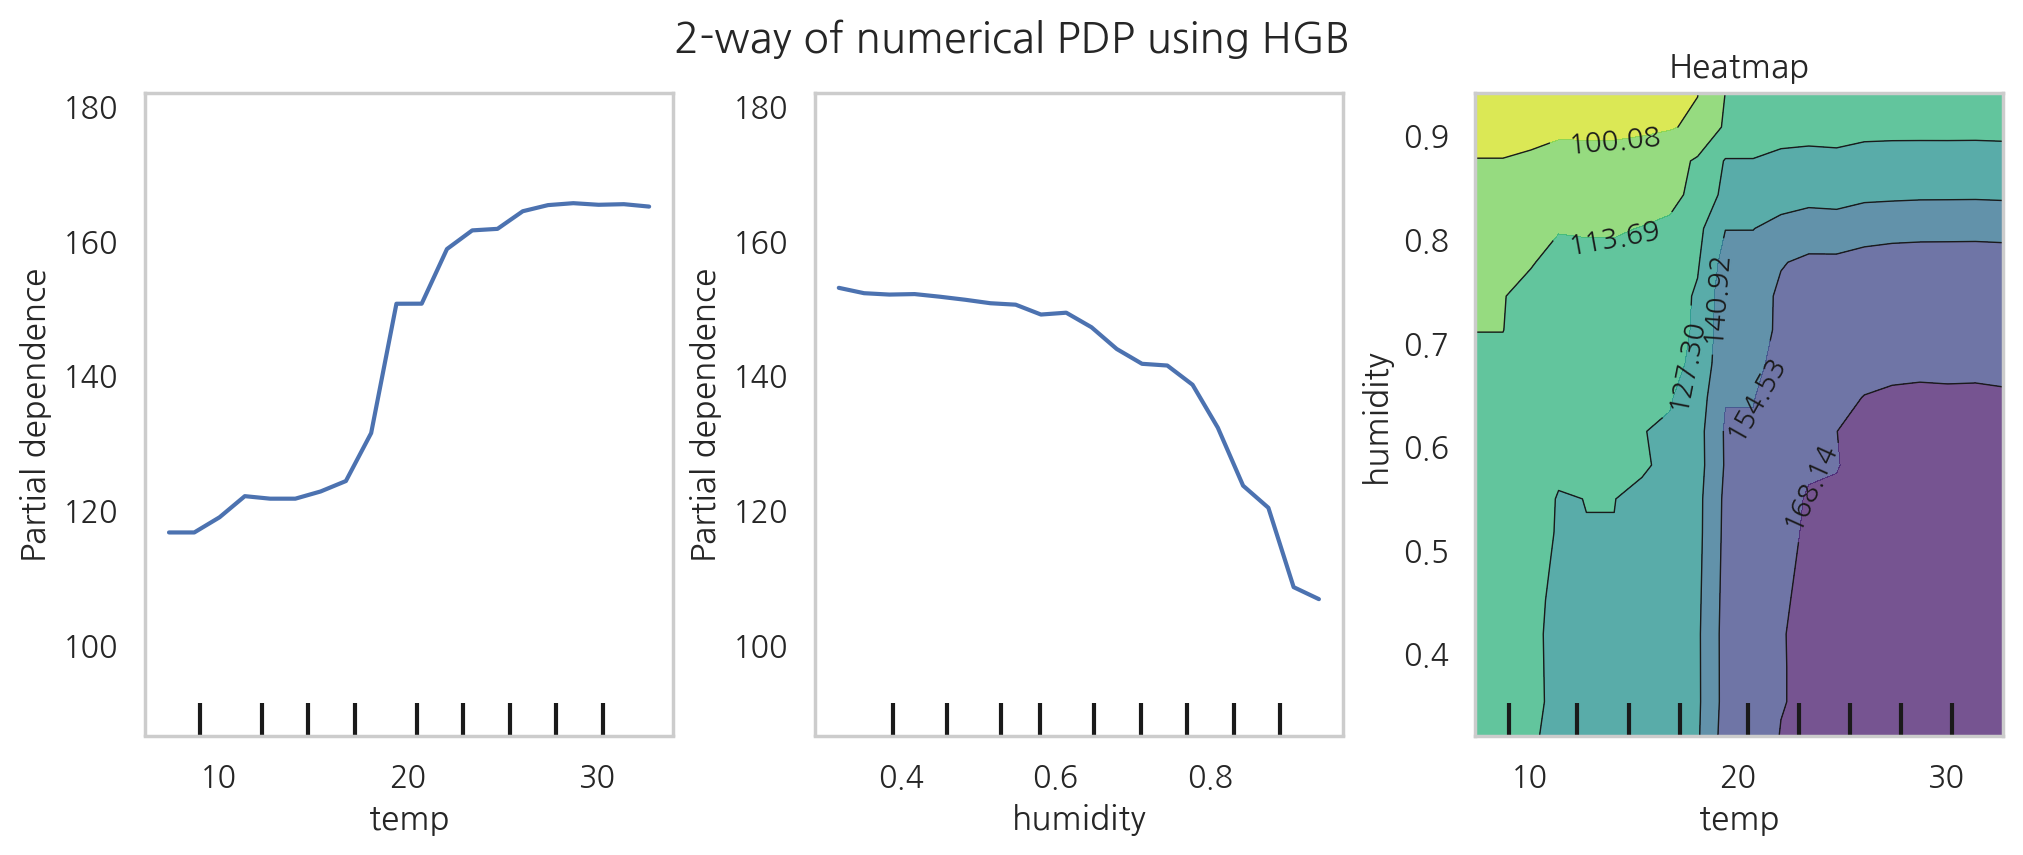

In [72]:
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

# 개별 axes setting : ax에는 3개의 axes 객체가 list에 들어 있음
ax[2].set_title("Heatmap")

disp = PartialDependenceDisplay.from_estimator(
    hgb_model,
    X_train,
    contour_kw={"cmap": "viridis_r"},
    **features_info,
    **common_params,
    ax=ax
)

_ = disp.figure_.suptitle("2-way of numerical PDP using HGB", fontsize=15, y=1.03)

### 상호작용을 제거한 모델의 2-way PDP
- model : hgb_model_without_interaction
- humidity 1-way (단방향) plot에서 스파이크를 확인 할 수 있다.
   - 그래프의 스파이크는 특정 훈련점에서 모델이 상호작용 반영을 금지한 것에 대해 반대작용으로 과적합 한 것으로 볼 수 있다.
   - HGB model에 상호작용 제약을 넣었으므로 최초 모델보다 성능이 낮다.
   - 이러한 스파이크의 형태는 grid_resolution 파라미터의 값에 의해 달라질 수 있다.
- humidity의 이러한 진동으로 인해 2-way PDP는 잡읍이 많은 격자형태가 된다.
   - heatmap에서 온도 20 이상에서 온도와 무관하게 습도가 target에 영향을 주는 것이 사라지게 된다.

In [73]:
features_info

{'features': ['temp', 'humidity', ('temp', 'humidity')],
 'kind': 'average',
 'categorical_features': Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
        'weather'],
       dtype='object')}

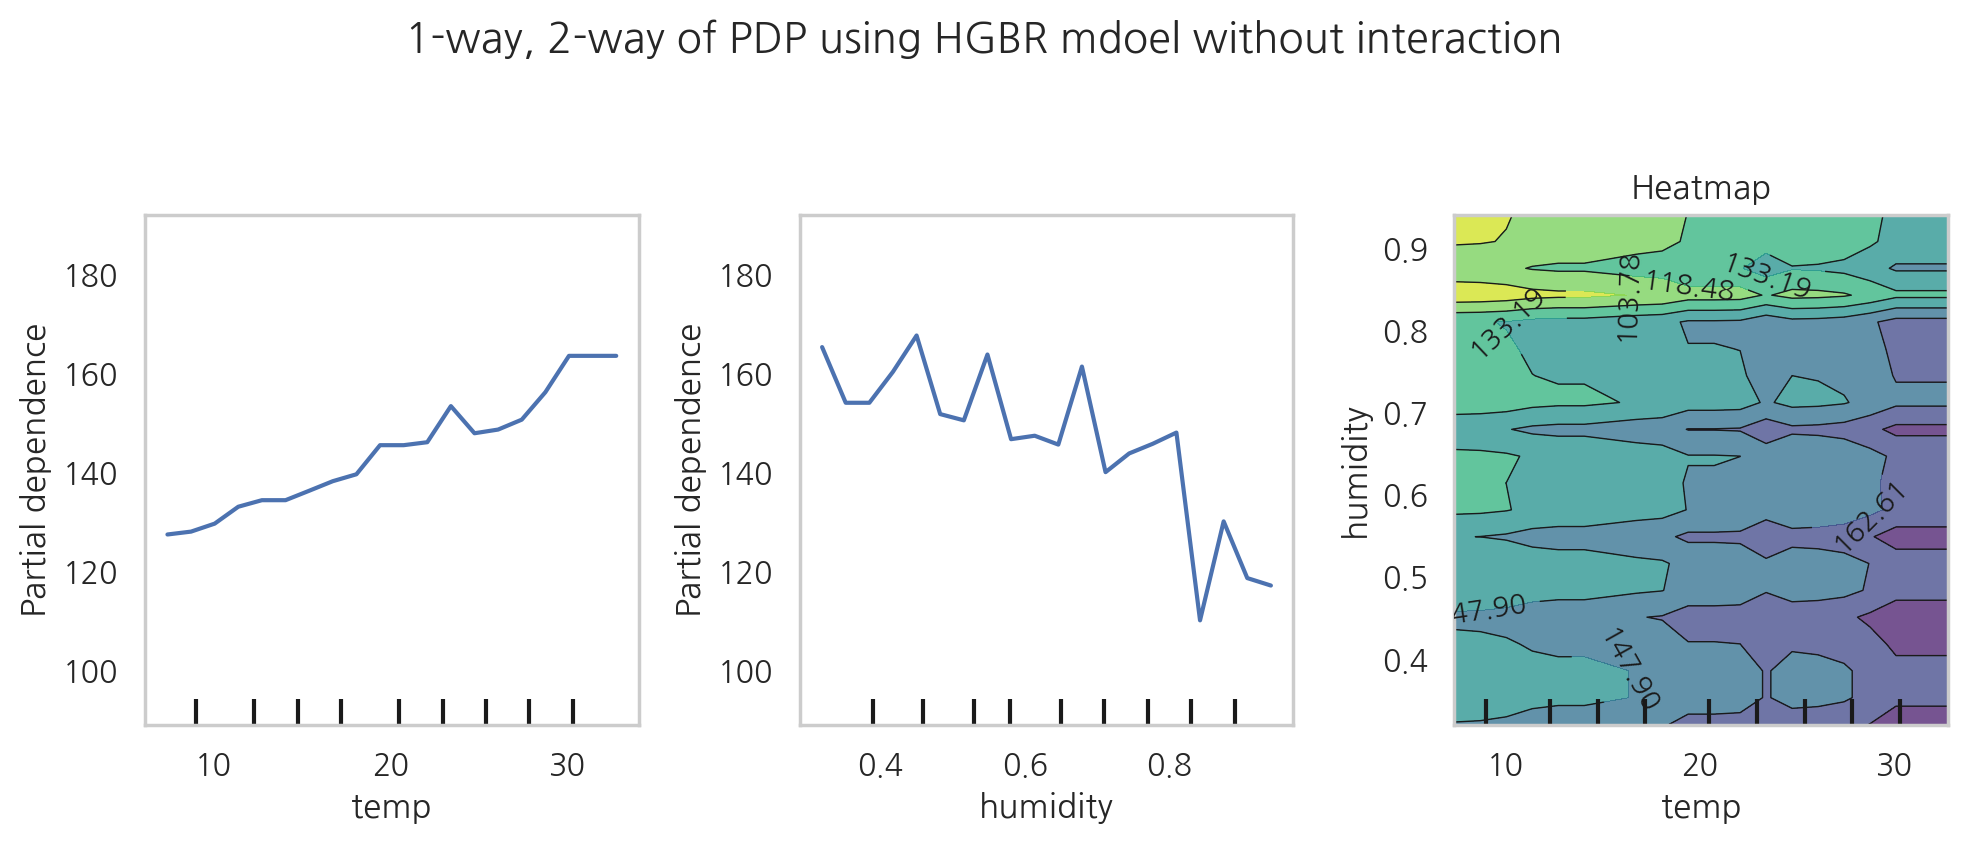

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
ax[2].set_title("Heatmap")
disp = PartialDependenceDisplay.from_estimator(
    hgb_model_without_interaction,
    X_train,
    **features_info,
    contour_kw={'cmap': 'viridis_r'},
    ax=ax,
    **common_params,    
)

fig.suptitle("1-way, 2-way of PDP using HGBR mdoel without interaction", 
             fontsize=15, y=1.05) 
plt.tight_layout()
plt.show() ;

### 상호작용 3가지 PDP

In [76]:
features_info["features"] = [
    ("temp", "humidity"),
    ("temp", "windspeed"),
    ("humidity", "windspeed")
]

features_info

{'features': [('temp', 'humidity'),
  ('temp', 'windspeed'),
  ('humidity', 'windspeed')],
 'kind': 'average',
 'categorical_features': Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
        'weather'],
       dtype='object')}

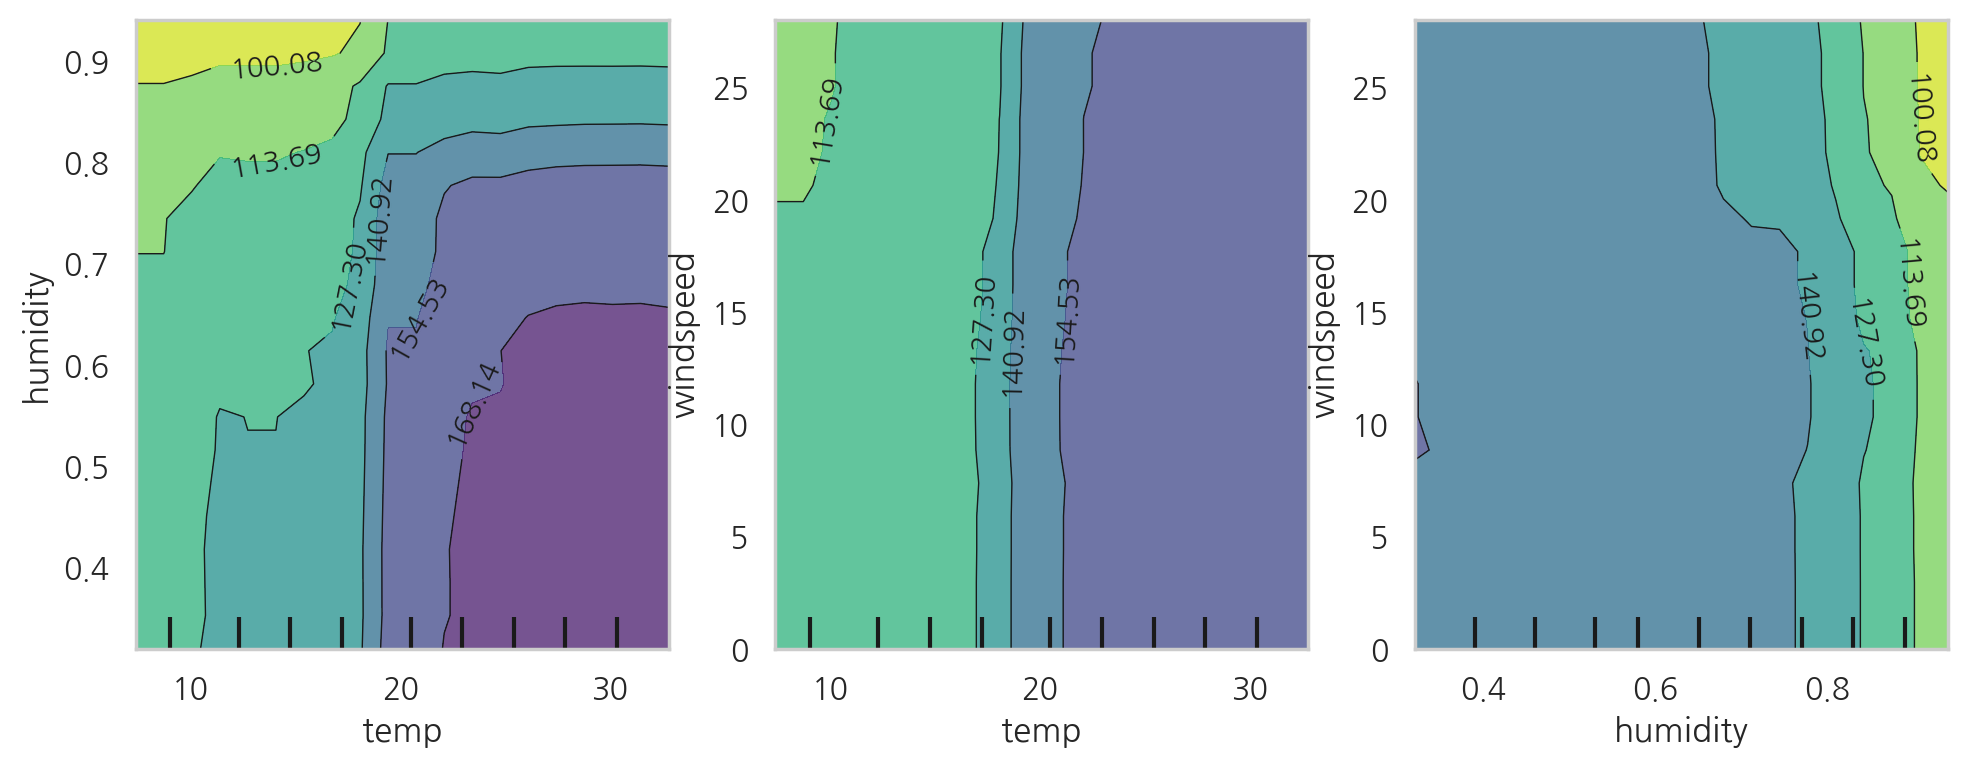

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))

disp = PartialDependenceDisplay.from_estimator(
    hgb_model,
    X_train,
    **features_info,
    contour_kw={"cmap": "viridis_r"},
    **common_params,
    ax=ax
)

plt.tight_layout() ;

## categorical features PD
- 범주형 독립변수간의 PDP

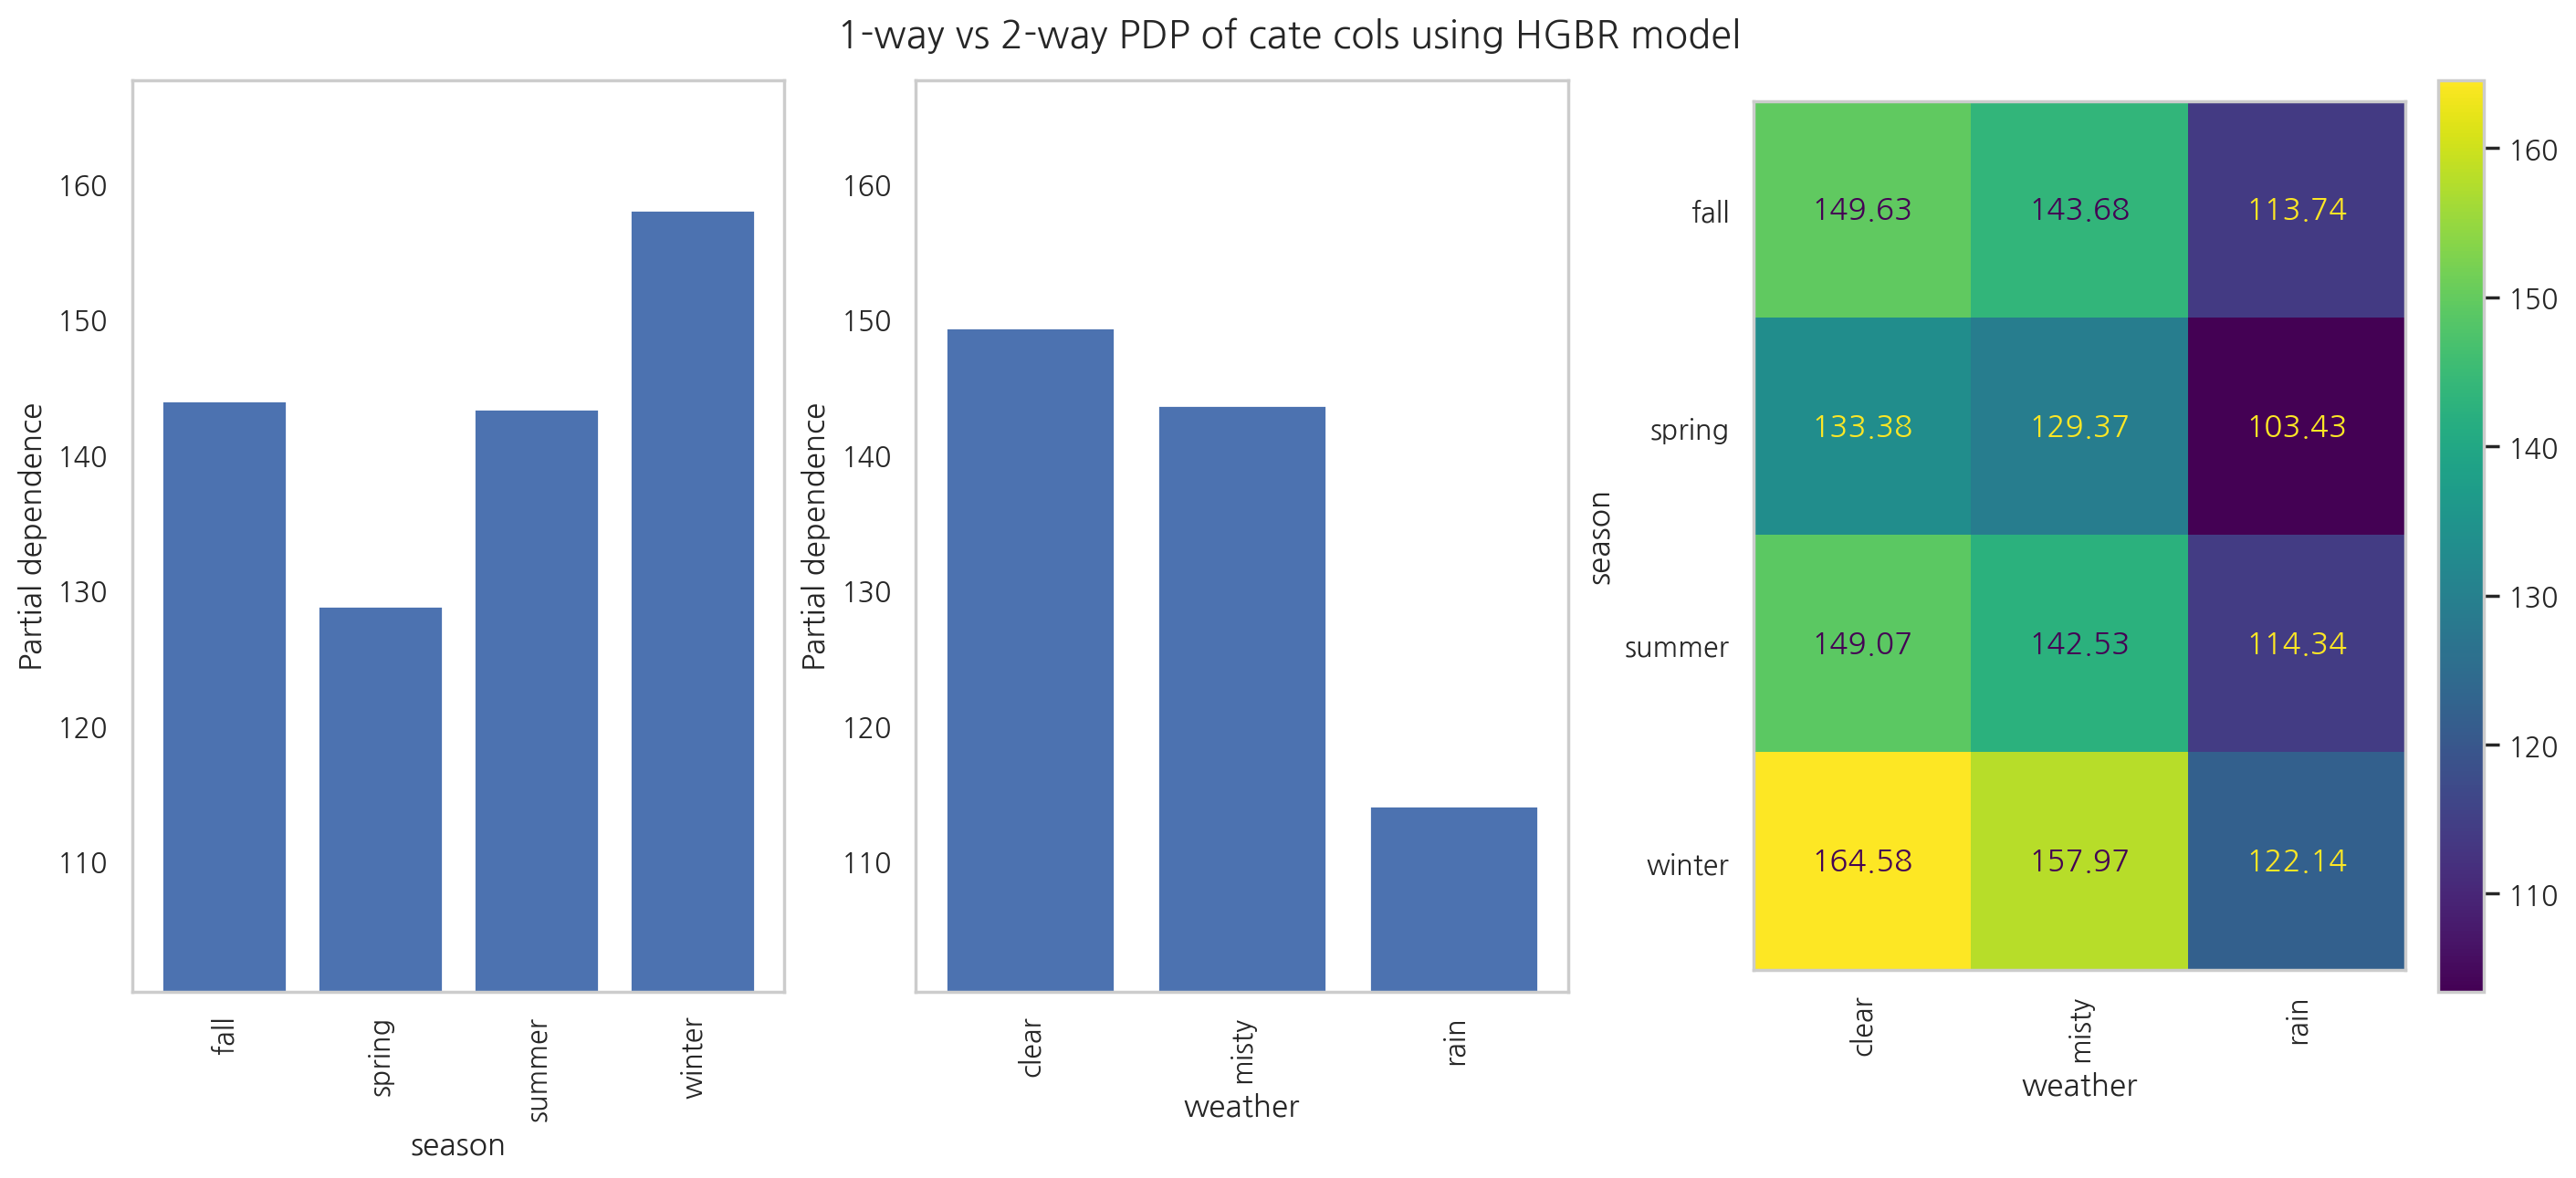

In [82]:
features_info["features"] = ["season", "weather", ("season", "weather")]

plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(ncols=3, figsize=(14, 6), constrained_layout=True)
disp = PartialDependenceDisplay.from_estimator(
    hgb_model,
    X_train,
    **features_info,
    **common_params,
    contour_kw={"cmap": "viridis_r"},
    ax=ax
)

_ = disp.figure_.suptitle("1-way vs 2-way PDP of cate cols using HGBR model",
                          fontsize=15, y=1.05)

## 3D representation

In [83]:
import mpl_toolkits.mplot3d
from sklearn.inspection import partial_dependence

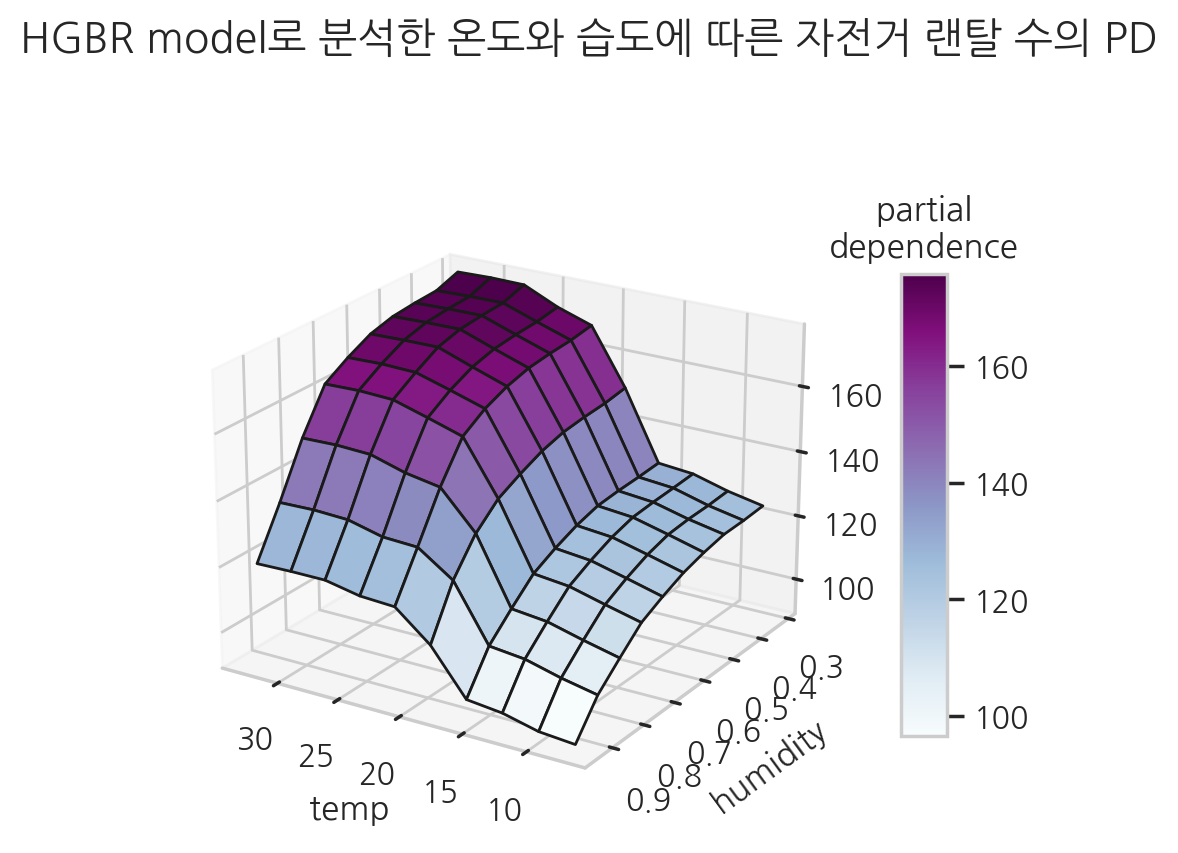

In [84]:
fig = plt.figure(figsize=(5.5, 5))

features = ("temp", "humidity")
pdp = partial_dependence(
    hgb_model,
    X_train,
    features=features,
    kind="average",
    grid_resolution=10)

# 3D projection graph
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, 
                       cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle("HGBR model로 분석한 온도와 습도에 따른 자전거 랜탈 수의 PD",
            fontsize=15)
ax.view_init(elev=22, azim=122)

# colorbar setting
clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("partial\ndependence")
plt.show() ; 

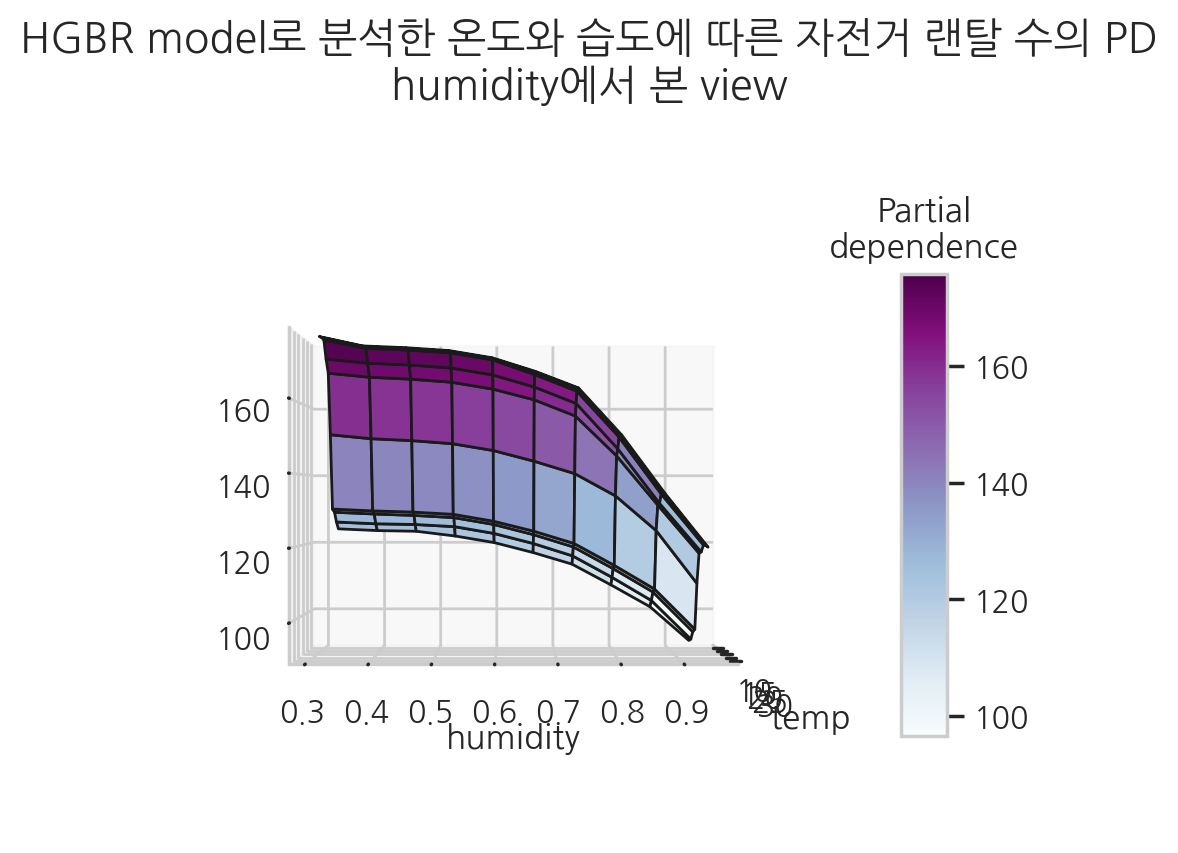

In [102]:
fig = plt.figure(figsize=(5.5, 5))

features = ("temp", "humidity")
pdp = partial_dependence(
    hgb_model,
    X_train,
    features=features,
    kind="average",
    grid_resolution=10)

# 3D projection graph
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T

ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, 
                       cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle("HGBR model로 분석한 온도와 습도에 따른 자전거 랜탈 수의 PD\n"
             "humidity에서 본 view",
            fontsize=15)
# humidity 축에서 바라본 view
ax.view_init(elev=0, azim=0)

clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show() ; 

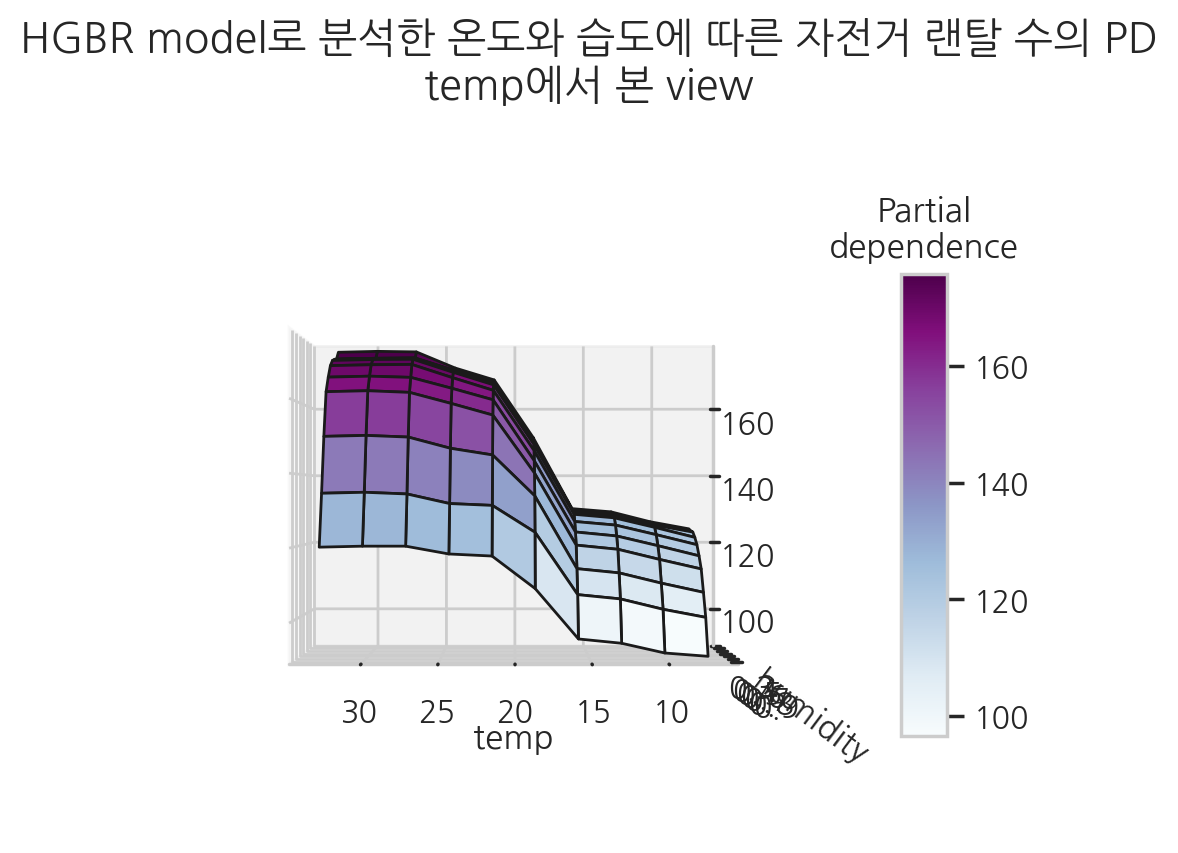

In [103]:
fig = plt.figure(figsize=(5.5, 5))

features = ("temp", "humidity")
pdp = partial_dependence(
    hgb_model,
    X_train,
    features=features,
    kind="average",
    grid_resolution=10)

# 3D projection graph
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T

ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, 
                       cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle("HGBR model로 분석한 온도와 습도에 따른 자전거 랜탈 수의 PD\n"
             "temp에서 본 view", fontsize=15)
# humidity 축에서 바라본 view
ax.view_init(elev=0, azim=90)

clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show() ; 